<a href="https://colab.research.google.com/github/qiwu-zhang/aps360_project/blob/main/APS360_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim
import requests
torch.manual_seed(50)

In [5]:
# import audio libraries
import os
from os import listdir
from os.path import join
from scipy.io import wavfile
import IPython.display as ipd

import librosa
from librosa.feature import melspectrogram
from librosa import power_to_db
from librosa.effects import trim

In [9]:
#Plot size
plt.rcParams['figure.figsize'] = [12, 8]

In [10]:
#Download team data from Google Drive
if(not os.path.exists("/team_data.zip")):
    team_data_url = "https://drive.google.com/uc?export=download&id=1eycnGtDVzqW57EUBEQmJDPz2F1Dqgqdc"

    resp = requests.get(team_data_url, stream=True)

    with open("/team_data.zip", 'wb') as fd:
        for chunk in resp.iter_content(chunk_size=128):
            fd.write(chunk)

In [11]:
#Download Kaggle data from Google Drive
if(not os.path.exists("/KaggleFSDD.zip")):
    kaggle_data_url = "https://drive.google.com/uc?export=download&id=1Uoy-XzAqE12FIPdqf9adFz7dfTcjDI9N"

    resp = requests.get(kaggle_data_url, stream=True)

    with open("/KaggleFSDD.zip", 'wb') as fd:
        for chunk in resp.iter_content(chunk_size=128):
            fd.write(chunk)

In [ ]:
if(not os.path.exists("/content/team_recordings")):
    !unzip '/team_data.zip' -d '/content/team_recordings'

In [ ]:
if(not os.path.exists("/content/kaggle_recordings")):
    !unzip '/KaggleFSDD.zip' -d '/content/kaggle_recordings'

In [14]:
# load audio files
def load_files(files, X, y):
  for file in files:
      label = int(file.split("_")[0])
      rate, data = wavfile.read(join(dir, file))
      X.append(data.astype(np.float32))
      y.append(label)
  return rate

X = []
y = []

# load team recordings
dir = '/content/team_recordings/all'
files = listdir(dir)
rate1 = load_files(files, X, y)

# load Kaggle recordings
dir = '/content/kaggle_recordings/recordings'
files = listdir(dir)
rate2 = load_files(files, X, y)

rate = min(rate1, rate2)

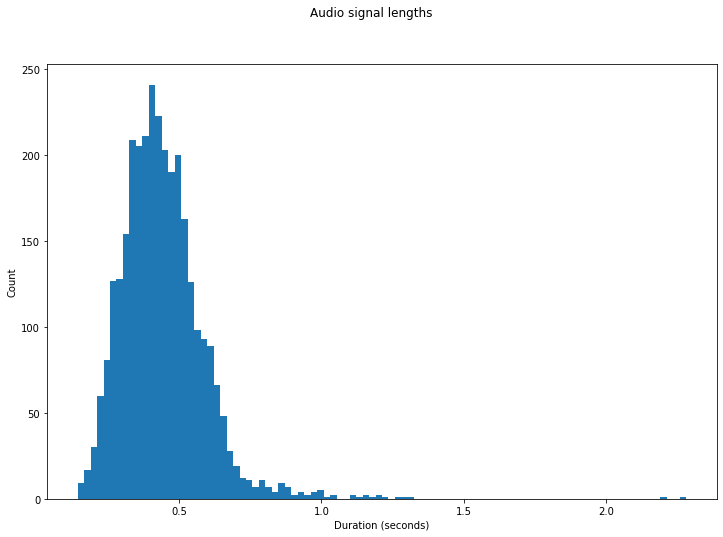

0.6635624999999996


In [15]:
# check distribution of length of audio clips

def show_length_distribution(signals, rate=8000):
    sample_times = [len(x)/rate for x in signals]

    fig = plt.figure()
    plt.hist(x=sample_times, bins = 'fd')
    fig.suptitle('Audio signal lengths')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')

    plt.show()
    return sample_times

lengths = show_length_distribution(X)
print(np.percentile(lengths, 95))

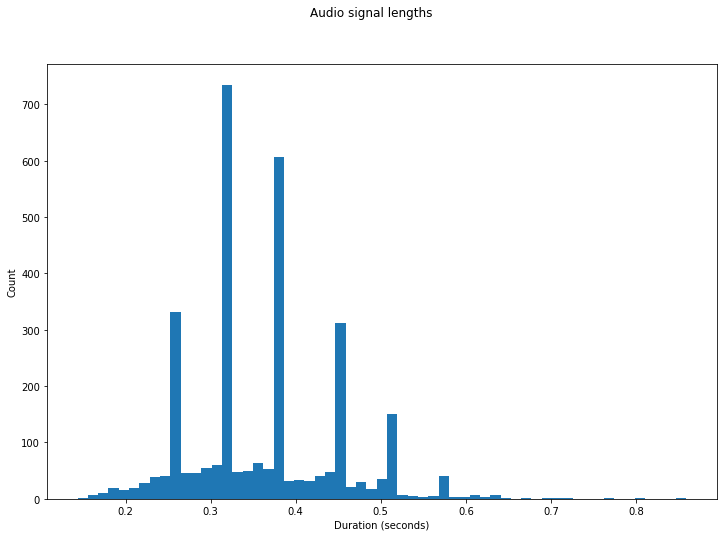

In [16]:
def remove_silence(sample, sr= 8000, top_db = 10):
    """This function removes trailing and leading silence periods of audio signals.
    """
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)
    return yt

    
X_tr = [remove_silence(x) for x in X]

show_length_distribution(X_tr);

In [18]:
# pad all clips to same length

N = int(rate * 0.7)
X_uniform = []
for x in X_tr:
    if len(x) < N:
        X_uniform.append(np.pad(x, (0, N - len(x)), constant_values = (0, 0)))
    else:
        X_uniform.append(x[:N])

Digit: 7


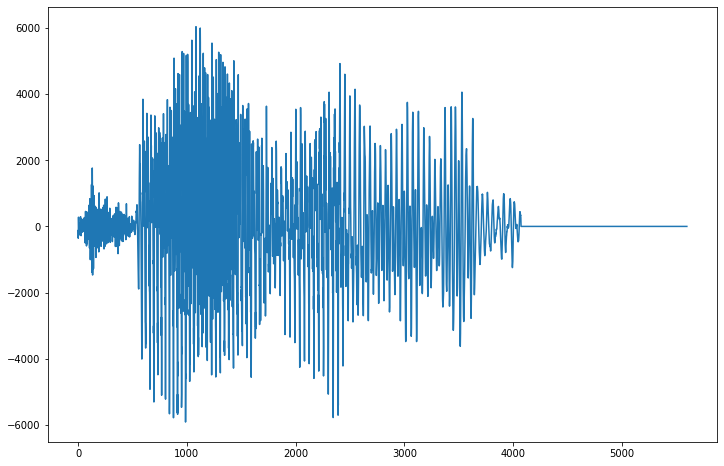

In [ ]:
# playback some audio clips

index = 3
print("Digit: {}".format(y[index]))
plt.plot(X_uniform[index])
plt.show()
ipd.Audio(X_uniform[index], rate=8000)

(128, 11)
[[3.47130625e+06 5.89812300e+06 7.22601200e+06 ... 1.05141650e+06
  3.83532031e+05 4.59239492e+04]
 [1.07097610e+07 1.22692410e+07 5.27274840e+07 ... 5.80678550e+06
  2.12042800e+06 1.31358562e+05]
 [1.18576900e+07 1.65672170e+07 1.01124336e+08 ... 3.55764775e+06
  7.87786375e+05 3.06902266e+04]
 ...
 [6.30786200e+06 1.66870180e+07 1.70949860e+07 ... 1.17440336e+05
  2.43893008e+04 1.84941931e+03]
 [3.16720800e+06 1.75377560e+07 1.99745880e+07 ... 2.85405500e+05
  3.65617422e+04 9.21586548e+02]
 [2.29943000e+06 7.69718600e+06 8.79932600e+06 ... 4.59354344e+05
  5.58707461e+04 1.82693982e+03]]


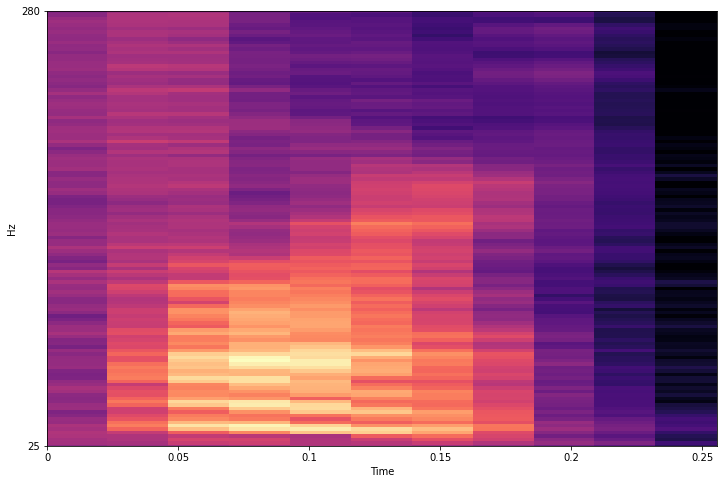

In [ ]:
from librosa import display
#S = librosa.util.normalize(X_uniform[4])      makes no difference to normalize...
S = librosa.feature.melspectrogram(y=X_uniform[4], sr=8000)
print(S.shape)
print(S)
display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', fmin=25, fmax=280)

#from scipy import signal
#frequencies, times, spectrogram = signal.spectrogram(X_uniform[4], 8000)
#plt.pcolormesh(times, frequencies, spectrogram)
#plt.imshow(spectrogram)
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')

#plt.show()
#for x in X_uniform[0]:
#   print(x)

In [ ]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Form the training, validation, and test sets
def get_data_sets(data, labels, training_percentage=0.7, use_mel=False):
  # subtraction is necessary below because we are using integers and do not want any data to be unused because of rounding down the integers
  train_len = int(len(data)*training_percentage)
  val_len = int(len(data)*(1-training_percentage)/2)
  test_len = len(data) - train_len - val_len
  
  if(use_mel):
      # Get melspectrograms of each sample
      mel_list = []
      for i in range(len(data)):
          S = librosa.feature.melspectrogram(y=data[i], sr=8000)
          S = S.flatten()
          mel_list.append(S)
      x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(mel_list, labels, test_size=val_len, random_state=1)
  else:
      x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(data, labels, test_size=val_len, random_state=1)

  x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x_train, y_train, test_size=test_len, random_state=1)

  return x_train, y_train, x_val, y_val, x_test, y_test

# Calc
def get_accuracy(classifier, x_data, y_data):
    pred = rfc.predict(x_data)
    correct = 0
    total = len(pred)
    for i in range(len(pred)):
        correct += pred[i] == y_data[i]

    return correct/total

In [ ]:
#For baseline model, will need to implement random forest classifier
#Will use the following links as guides: (moreso the second link)
#https://medium.com/@pratyush.sinha/training-random-forest-by-back-propagation-for-fun-pytorch-part-1-a54674355aa7
#https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652

rfc = RandomForestClassifier(random_state=10, n_estimators=100, max_features=100, warm_start=True, min_samples_leaf=10, verbose=True, n_jobs=-1)
x_train, y_train, x_val, y_val, x_test, y_test = get_data_sets(X_uniform, y, use_mel=True)
rfc.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=100,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=10,
                       verbose=True, warm_start=True)

In [ ]:
print("Validation Accuracy: {}%".format(100*get_accuracy(rfc, x_val, y_val)))
print("Test Accuracy: {}%".format(100*get_accuracy(rfc, x_test, y_test)))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Validation Accuracy: 89.1025641025641%
Test Accuracy: 89.74358974358975%


In [ ]:
# After receiving necessary tensors

def get_data_loader(data, batch_size, training_percentage=0.7):
  # subtraction is necessary below because we are using integers and do not want any data to be unused because of rounding down the integers
  train_len = int(len(data)*training_percentage)
  val_len = int(len(data)*(1-training_percentage)/2)
  test_len = len(data) - train_len - val_len
  train_set, val_set, test_set = torch.utils.data.random_split(data, [train_len, val_len, test_len])

  train_loader = DataLoader(train_set, batch_size, shuffle=True)
  if val_len > 0:
    val_loader = DataLoader(val_set, batch_size, shuffle=True)
  else:
    val_loader = []
  if test_len > 0:
    test_loader = DataLoader(test_set, batch_size, shuffle=True)
  else:
    test_loader = []

  return train_loader, val_loader, test_loader

batch_size = 64
#dataset = TensorDataset(torch.from_numpy(datanp))
#dataset = TensorDataset(data)
#train_loader, val_loader, test_loader = get_data_loader(dataset, batch_size)

In [ ]:
#For baseline model, will need to implement random forest classifier
#Will use the following links as guides: (moreso the second link)
#https://medium.com/@pratyush.sinha/training-random-forest-by-back-propagation-for-fun-pytorch-part-1-a54674355aa7
#https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc = RandomForestClassifier(random_state=10, n_estimators=100, max_features=100, warm_start=True, min_samples_leaf=10, verbose=True, n_jobs=-1)

#Because we set warm start to true, we can fit the decision trees batch by batch

def train(model, train_loader, val_loader, num_epochs=1):
    acc = np.zeros(num_epochs)
    for epoch in range(num_epochs):    #I don't think we even need more than one, but try it and see cuz idk
        for input, labels in enumerate(train_loader, 0):
            #replace 784 with number of pixels per spectrogram... idk how many as of yet
            input = input.view(-1, 784)
            model.fit(input, labels)
        acc[epoch] = get_accuracy(model, val_loader)

    #rough stuff
    print(acc)

def get_accuracy(model, data_loader):
    return 0

